# **Prediction for elementary RL problems**
Objectives: understanting the concept of prediction in RL for a simple grid-world environment and implement the first-visit Monte Carlo (MC)

1.   Understand the concept of estimating a policy in model-based (Policy Evaluation) and model-free (MC) scenarios
2.   Implement and train the first-visit MC algorithm on the grid-world environment


# Environment

In [ ]:
from typing import Dict, List, Optional, Tuple
from matplotlib import pyplot as plt

import dataclasses
import numpy as np

global figsize
figsize = (4,4)

In [ ]:
# transition class
@dataclasses.dataclass
class Transition:
    state: Tuple[int, int]
    action: str
    next_state: Tuple[int, int]
    reward: float
    termination: bool

# main environment class
class GridEnv:
    '''
    _states: np.array
    _rewards: np.array
    _action_semantics: List[str]
    _actions: Dict[str, np.array]
    _init_state: Tuple[int, int]
    _current_state: Tuple[int, int]
    _goal: Tuple[int, int]
    _transition_probabilities: np.array
    '''
    def __init__(self,
                 rows: int,
                 cols: int,
                 step_cost: float,
                 goal: Tuple[int, int],
                 obstacles: Optional[List[Tuple[int, int]]] = None) -> None:
        self._states = np.zeros((rows, cols))

        obstacles = [] if obstacles is None else obstacles
        self._obstacles = obstacles

        for r, c in obstacles:
            self._states[r, c] = 1

        self._rewards = -step_cost*np.ones((rows, cols))
        self._rewards[goal[0], goal[1]] = +1

        self._action_semantics = ['up', 'left', 'down', 'right']
        self._actions = np.array([[-1, 0], [0, -1], [1, 0], [0, 1]])
        self._init_state = (rows - 1, 0)
        self._current_state = self._init_state
        self._goal = goal

        # the probability left and right of the chosen action
        self._transition_probabilities = np.array([0.1, 0.8, 0.1])

    @property
    def actions(self) -> List[str]:
        return self._action_semantics

    @property
    def current_state(self) -> Tuple[int, int]:
        return self._current_state

    @property
    def reward(self) -> float:
        r, c = self._current_state
        return self._rewards[r, c]

    @property
    def termination(self) -> bool:
        return self._current_state == self._goal

    def render(self, hide_agent=False) -> None:

        grid = np.array(self._states, dtype=str)
        r, c = self._current_state
        if not(hide_agent):
          grid[r, c] = 'x'
        r, c = self._goal
        grid[r, c] = 'G'


        # Map colors to each cell in the grid

        color_map = {'x': [0, 0, 255],
                     '0.0': [0, 0, 0],
                     '1.0': [255, 0, 0],
                     'G': [0, 255, 0]}

        color_grid = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.uint8)
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                color_grid[i, j] = color_map.get(grid[i, j])

        plt.figure(figsize=figsize)
        plt.imshow(color_grid)
        plt.axis('off')

    def _transition(self, state: Tuple[int, int], a: np.array) -> Tuple[int, int]:
        """
        state: 2D coordinates of current state at grid
        a: The index of the selected action [-1,4]
        return The next state coordinates
        """
        n_actions = len(self._actions)
        # Reassigns the a index within the bounds of the number of actions
        # If it is less than 0 then a = index + number of actions else a = index mod number of actions
        a = self._actions[a + n_actions if a < 0 else a % n_actions]

        '''
        Take max in order to be in boundries
          1) min ( max grid size , next state size)
          2) max (0,  (1) )
        '''

        new_r = max(0, min(self._states.shape[0] - 1, state[0] + a[0]))
        new_c = max(0, min(self._states.shape[1] - 1, state[1] + a[1]))

        # Last check if we can move at the next state. The next state is not an obstacle
        return (new_r, new_c) if self._states[new_r, new_c] == 0. else state

    def step(self, action: str) -> Transition:
        '''
         action = String, the semantic of the action
        '''

        a_idx = self._action_semantics.index(action)

        # The probability distribution self._transition_probabilities selects if the choosen action will change.
        # If yes the index will be moved one step to the right or left
        chosen_action = a_idx + np.random.choice([1, 0, -1], p=self._transition_probabilities)
        prev_state = self._current_state
        self._current_state = self._transition(self._current_state, chosen_action)

        return Transition(state=prev_state,
                          action=action,
                          next_state=self._current_state,
                          reward=self.reward,
                          termination=self.termination)

    def reset(self) -> None:
        self._current_state = self._init_state

Inspect environment visualization, state, reward, termination, and action format

Current State: (4, 0)
Reward: -0.4
Termination: False
Actions: ['up', 'left', 'down', 'right']


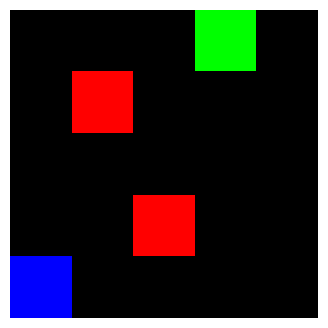

In [ ]:
my_env = GridEnv(rows=5, cols=5, step_cost=0.4, goal=(0, 3), obstacles=[(1, 1), (3,2)])
my_env.render()
print("Current State:", my_env.current_state)
print("Reward:", my_env.reward)
print("Termination:", my_env.termination)
print("Actions:", my_env.actions)


right
Transition(state=(4, 0), action='right', next_state=(4, 1), reward=-0.4, termination=False)
up
Transition(state=(4, 1), action='up', next_state=(3, 1), reward=-0.4, termination=False)
left
Transition(state=(3, 1), action='left', next_state=(3, 0), reward=-0.4, termination=False)
up
Transition(state=(3, 0), action='up', next_state=(2, 0), reward=-0.4, termination=False)
left
Transition(state=(2, 0), action='left', next_state=(2, 0), reward=-0.4, termination=False)


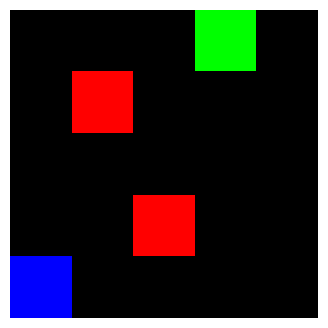

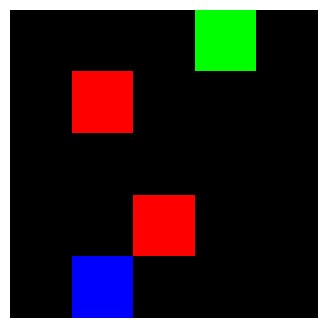

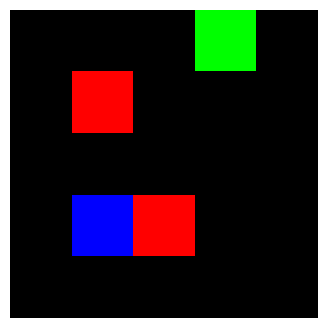

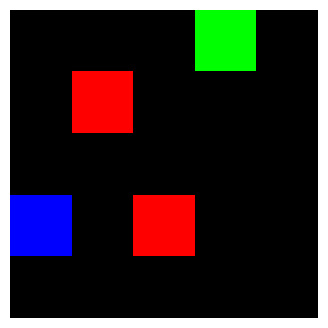

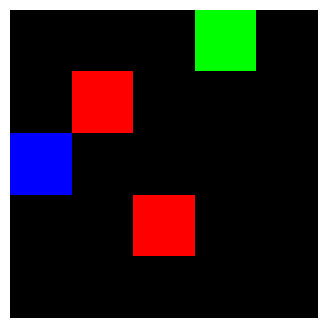

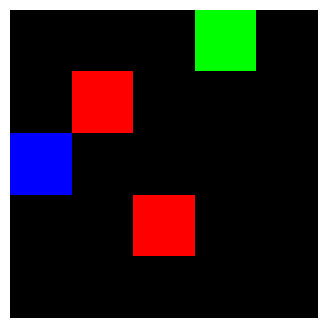

In [ ]:
my_env.render()
for _ in range(5):
    a = np.random.choice(my_env.actions)
    print(a)
    print(my_env.step(a))
    my_env.render()

# Policy Evaluation (DP)
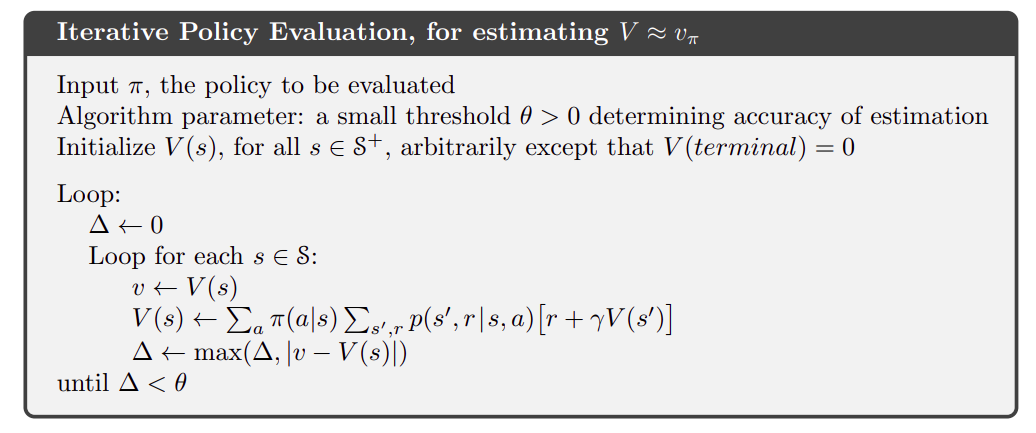

In [ ]:
size_r = my_env._states.shape[0]
size_c = my_env._states.shape[1]

V = np.zeros((size_r, size_c))
gamma = 0.8
max_error = 1e-8
delta_store = []

# give to the get_v function the number of row, column and
# return the specific value from the V function
get_v = lambda r, c: V[r, c]

while True:
  delta = 0
  V_prime = V.copy()
  # policy evaluation
  for i in range(size_r*size_c):
      r = i // size_c
      c = i % size_c

      if (r,c) in my_env._obstacles:
        V[r, c] = None
        continue

      reward = my_env._rewards[r, c]
      actions = my_env._actions

      # Perform the Bellman expectation update
      value_per_action = [0.0] * len(actions)
      for a_idx in range(len(actions)):
          possible_outcomes = [my_env._transition((r, c), a) for a in a_idx + np.array([1, 0, -1])]
          v = sum([my_env._transition_probabilities[k]*(reward + gamma *get_v(*list(s_prime)))
            for k, s_prime in enumerate(possible_outcomes)])
          value_per_action[a_idx] = v

      # taking the mean corresponds to the uniform random policy (i.e., in this environment: 0.25 * v_next_state)
      value = np.mean(value_per_action)
      V_prime[r, c] = value
      err = abs(V[r, c] - V_prime[r, c])
      delta = err if err > delta else delta

      V = V_prime
      # store deltas for visualizations
      delta_store.append(delta)

  # stopping condition
  if delta < max_error:
      break


[[-1.88728648 -1.7091746  -1.24023734  0.34418709 -1.06812746]
 [-1.95268487         nan -1.59596184 -1.31488687 -1.54856949]
 [-1.97076815 -1.94484071 -1.82872316 -1.77409009 -1.81126362]
 [-1.98554704 -1.97987154         nan -1.91557684 -1.92239488]
 [-1.99154848 -1.9890984  -1.98497359 -1.96582238 -1.96273909]]


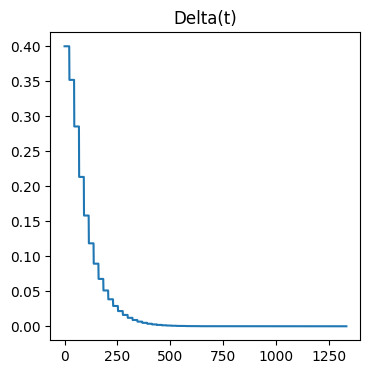

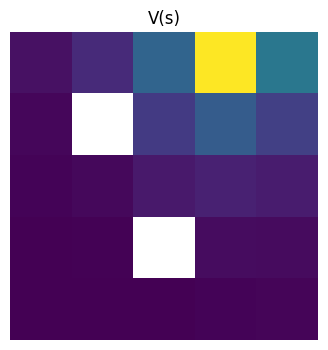

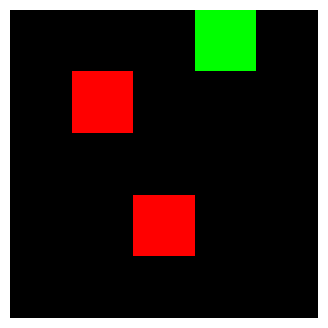

In [ ]:
# visualize delta, V(s), and environment

plt.figure(figsize=figsize)
plt.plot(delta_store)
plt.title('Delta(t)')

plt.figure(figsize=figsize)
plt.imshow(V)
plt.title('V(s)')
plt.axis('off')

my_env.render(hide_agent=True)

print(V)

# Every-visit MC

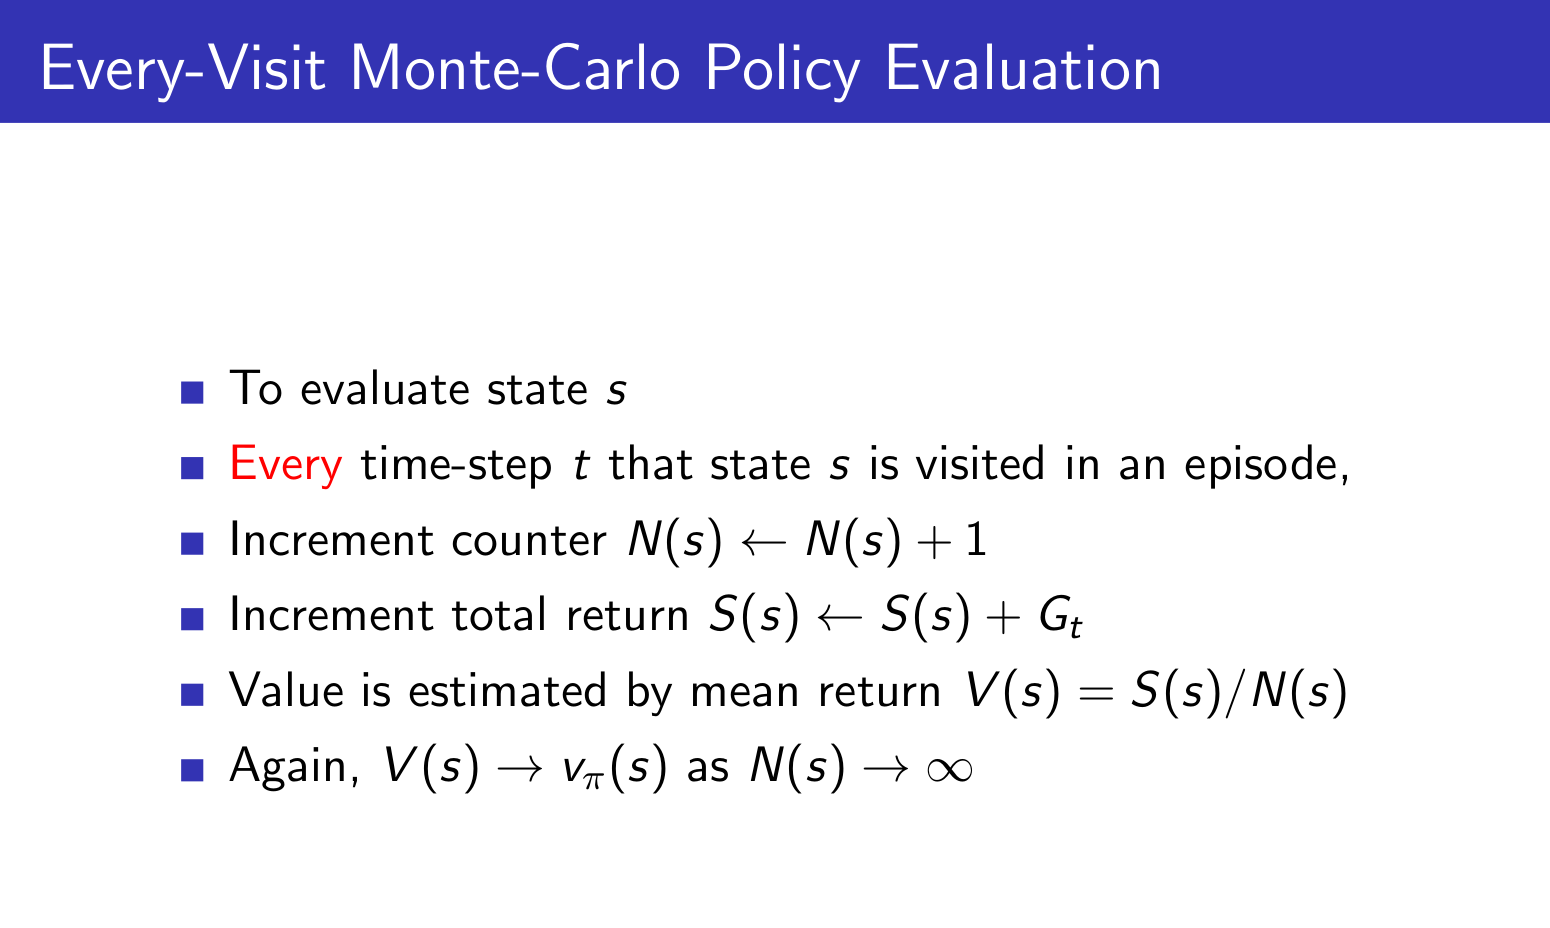

In [ ]:
my_env = GridEnv(rows=5, cols=5, step_cost=0.4, goal=(0, 3), obstacles=[(1, 1), (3,2)])

size_r = my_env._states.shape[0]
size_c = my_env._states.shape[1]
num_episodes = 1000

In [ ]:
import random
# TO DO: initialize number of visits per state
N = np.zeros((size_r, size_c))
# TO DO: initialize returns per state
G = np.zeros((size_r, size_c))

# loop through the episodes
for ep in range(num_episodes):

  # initialize list to store visited states and returns per episode
  s = []
  r = []
  ep_step = -1

  # reset environment at the beginning of each episode
  my_env.reset()
  transition = Transition(state=(0, 0), action='none', next_state=(0, 0), reward=0, termination=False)
  # TO DO: change terminating condition for the environment
  while not(transition.termination):

    ep_step += 1 # update counter for steps in each episode
    # TO DO: sample action according to random policy
    actions = my_env.actions
    # print(actions)
    a = random.sample(actions, 1)[0]
    # print(a)

    # TO DO: execute the transition given chosen action and store previous state and obtained reward. Hint: use the environment step method and output
    transition = my_env.step(a)

    # TO DO: store visited states
    s.append(transition.next_state)

    # TO DO: store rewards
    r.append(transition.reward)

  g = 0
  for t in range(ep_step, 0, -1):
    g += r[t]
    # TO DO: update returns and visits per visited state
    N[s[t]] = N[s[t]] + 1
    G[s[t]] = G[s[t]] + g

# TO DO: compute value function
V = np.divide(G, N)

<ipython-input-22-d092b3fddf9c>:45: RuntimeWarning: invalid value encountered in divide
  V = np.divide(G, N)


[[-25.52021978 -19.44296843 -11.13713528   1.          -5.88309179]
 [-29.46147893          nan -16.40615977 -12.59698303 -14.59211823]
 [-32.40034892 -30.03987995 -23.51426851 -21.20784593 -23.27346939]
 [-36.50569889 -34.41877256          nan -27.07429707 -28.47261733]
 [-36.3264553  -34.99081967 -33.00279911 -30.67373313 -30.15810909]]


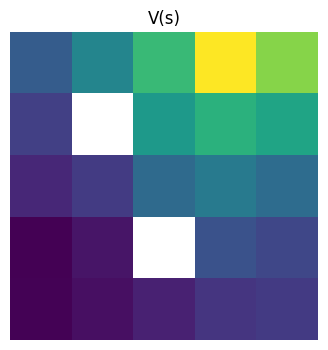

In [ ]:
# visualize V(s) learned through interactions with the environment. Is it similar to the one learned with Value Iteration?
print(V)

if V is not None:
  plt.figure(figsize=figsize)
  plt.imshow(V)
  plt.title('V(s)')
  plt.axis('off')